In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets as mf2_sets
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap
from scipy.signal import find_peaks


In [472]:
seed =10
N = 500
theta_random,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) - np.mean(omega)
dt = 0.1
t_end = 5000
m = 6
K = 1.5
t = np.arange(0,t_end,dt)
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(200))*int(1/dt))
if m == 0:
    dtheta = np.c_[dtheta[0],dtheta.T].T
r_duration = rs[-5000:]
r = np.mean(r_duration)
rstd = np.std(r_duration)
rMM = np.max(r_duration)-np.min(r_duration)
dtheta_c = np.cumsum(dtheta,axis=0)
r_c = np.cumsum(rs,axis=0)
sum_time = 100*int(1/dt)
t_sum = t[sum_time:]
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
avg_r = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [473]:
dtheta.shape

(2000, 500)

In [474]:
temp = avg_dtheta[-1]

In [475]:
def to_cluster_barg(idx,peaks_new):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = np.arange(arg_C[0],arg_C[1])
    return cluster
def to_cstability(x,diff_dtheta):
    try:
        return np.mean(diff_dtheta[x[1:]])
    except IndexError:
        return np.nan
def to_slope(x,SD):
    try:
        return np.polyfit(np.arange(len(x)),SD[x],1)[0]
    except IndexError:
        return np.nan
def to_mean_avg_d_o(x,avg_dtheta,index):
    try:
        return np.mean(avg_dtheta[index][x])
    except IndexError:
        return np.nan

In [476]:
def cluster_os_single(avg_dtheta,N,cidx=False):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_slope(x,SD):
        try:
            return np.polyfit(x,SD[x],1)[0]
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    index = -1
    arg = np.argsort(avg_dtheta[index])
    SD = avg_dtheta[index][arg]
    diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
    peaks, P  = find_peaks(diff_dtheta, height=0.01)

    # peaks = peaks[np.where((peaks<N)&(peaks>1))]

    try:
        peaks_new = np.array([peaks[0],*peaks])
        if len(peaks) == 1:
            peaks_new = np.array([peaks[0],N])

    except IndexError:
        peaks_new = np.array([0,N])


        

    psize = np.diff(peaks_new)
    arg_psize = np.argsort(psize)[::-1]
    sort_psize = np.sort(psize)[::-1]
    clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]

    if len(clusters) == 1:
        clusters = np.array([np.arange(peaks_new[0],N)])
    c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
    c_slope = np.array(list(map(to_slope,clusters,[SD]*len(clusters))))
    mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
    Is_group, = np.where((c_slope<1e-3))
    Is_group

    CM_O = mean_omega[Is_group]
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.sort(psize)[::-1][Is_group][sCM_Oidx]
    C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,c_slope
    else:
        return CM_S,sCM_O

In [477]:
CM_S,sCM_O,C_idx,c_slope = cluster_os_single(avg_dtheta,N,cidx=True)
print(c_slope)

[0.00076901 0.00049983 0.00204285 0.00011596 0.00419884 0.00287703
 0.00420825 0.00382498 0.00537295 0.00197405]


/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/4257303779.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/4257303779.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


(<Figure size 640x200 with 2 Axes>, [<matplotlib.lines.Line2D at 0x16cb66950>])

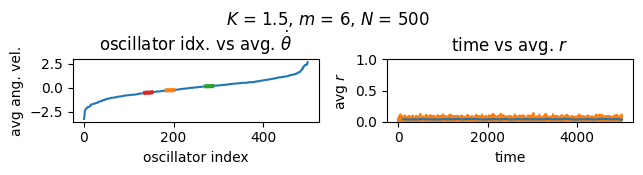

In [478]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx),plt.plot(t,rs,zorder=0)

In [126]:
CM_S,sCM_O,C_idx,check_,psize_array,slope_array =cluster_os(avg_dtheta,N,cidx=True,dt=0.01)
print(check_,CM_S)

0 [ 78. 261.  59.]


/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/4239498861.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


array([ 78., 261.,  59.])

In [130]:
np.mean(psize_array,axis=1)

array([261.        ,  78.        ,  59.        ,  17.        ,
         7.04333333,   5.35666667,   5.        ,   5.        ,
         5.        ,   4.89333333])

In [135]:
np.min(slope_array,axis = 1)

array([-0.00012627, -0.00026197, -0.00018715, -0.0001791 , -0.00034489,
       -0.00037505, -0.00037776, -0.00037776, -0.00037776, -0.00040207])

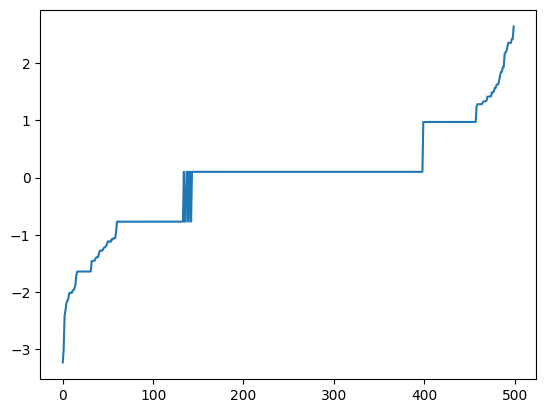

In [132]:
plt.plot(avg_dtheta[-1])

ValueError: x and y can be no greater than 2D, but have shapes (20000,) and (20000, 10, 1)

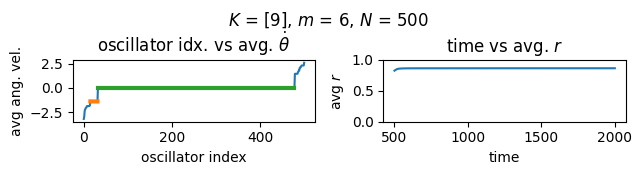

In [93]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx),plt.plot(t,rs,zorder=0)

In [32]:
K_set = np.arange(0,10,0.5).reshape(-1,1)
seed = 10
m = 0
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
omega_sets = (np.ones((N_set,1))*omega)


m = 0
t_end = 2000
dt =0.1
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets(K_set,N=N,m=m,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-300)*(1/dt)))
if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)

In [33]:
dtheta_set.shape

(3000, 20, 500)

In [34]:
dtheta_set[::10]

array([[[-3.23541133, -3.01060676, -2.426582  , ...,  2.43431509,
          2.43664107,  2.64890032],
        [-3.22701656, -2.99426943, -2.44624988, ...,  2.45358746,
          2.45325328,  2.62817854],
        [-3.27934501, -3.08083525, -2.40741096, ...,  2.38537966,
          2.43562409,  2.61243581],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-3.23541133, -3.01060676, -2.426582  , ...,  2.43431509,
          2.43664107,  2.64890032],
        [-3.25554893, -3.03346122, -2.42941751, ...,  2.42011243,
          2.41366541,  2.67128178],
        [-3.1523566 , -2.90223797, -2.35413439, ...,  2.54256534,
          2.52461186,  2.61025043],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [42]:
sum_time = 500*int(1/dt)
def to_avg(dtheta,sum_time=100*int(1/dt)):
    dtheta_c = np.cumsum(dtheta,axis=0)
    avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    return avg_dtheta
avg_dtheta_set = to_avg(dtheta_set,sum_time = sum_time)

In [22]:
r_c = np.cumsum(rs.T[0].T,axis=0)
sum_time = 50*int(1/dt)
t_sum = t[sum_time:]
avg_r_set = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

In [34]:
r_duration = rs[-5000:,:]
r = np.mean(r_duration,axis=0).reshape(-1)
rstd = np.std(r_duration,axis=0).reshape(-1)
rMM = np.max(r_duration)-np.min(r_duration)

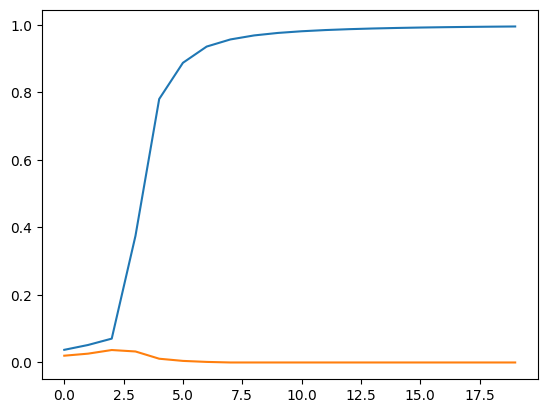

In [36]:
plt.plot(r)
plt.plot(rstd)

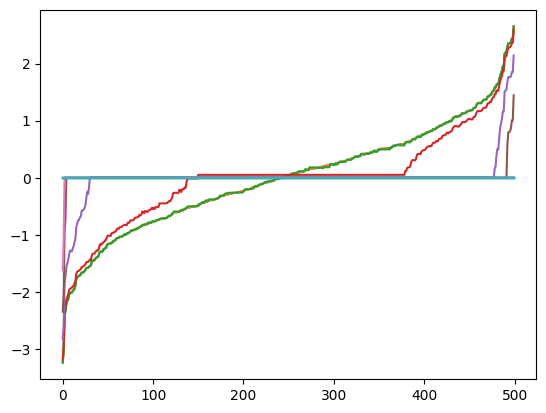

In [23]:
plt.plot(avg_dtheta_set[-1].T);

In [449]:
rs.shape

(20000, 20, 1)

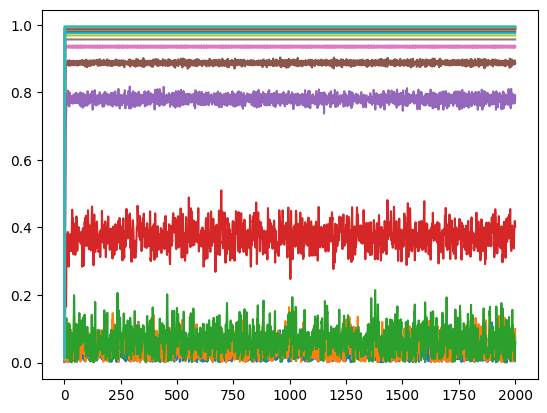

In [24]:
r = rs.T[0].T
plt.plot(t,r)

In [257]:
np.polyfit([1,2,3],[1,1,1,],1)[0]

-8.185332456055529e-17

In [25]:
def cluster_os(avg_dtheta,N,cidx=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 1000
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
            if len(peaks) == 1:
                peaks_new = np.array([peaks[0],N])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    mm = np.max(psize_array,axis=1) - np.min(psize_array,axis=1)
    # Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))
    Is_group, = np.where((mm <= 1)&(psize_array[:,-1]>3))
    check_ = 0
    min_group_s = np.min(c_stability_array,axis=1)
    max_group_s = np.max(c_stability_array,axis=1)
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((min_group_s<5e-4)&(psize_array[:,-1]>3))
    Is_group3, = np.where((max_group_s<2e-3))
    Is_group = np.intersect1d(np.intersect1d(Is_group,Is_group2),Is_group3)
    if len(Is_group)==0:
        check_ = 1
        # Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))
        Is_group, = np.where((min_group_s<1e-5)&(mm <= 1)&(psize_array[:,-1]>3))

    # if len(Is_group)==0:
    #     check_ = 2
    #     mean_group_s = np.mean(c_stability_array,axis=1)
    #     Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,check_,psize_array
    else:
        return CM_S,sCM_O,check_

In [479]:
def cluster_os(avg_dtheta,N,cidx=False,p_array=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 200
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
            if len(peaks) == 1:
                peaks_new = np.array([peaks[0],N])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>3))
    check = 0
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((mean_group_s<6e-4)&(psize_array[:,-1]>3))
    Is_group = np.intersect1d(Is_group,Is_group2)
    if len(Is_group)==0:
        check = 1
        mm = np.max(psize_array,axis=1) - np.min(psize_array,axis=1)
        # Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>10))
        Is_group, = np.where((c_stability<5e-4)&(mm <= 1))

    # if len(Is_group)==0:
    #     check = 2
    #     mean_group_s = np.mean(c_stability_array,axis=1)
    #     Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,check,psize_array
    if p_array == True:
        return CM_S,sCM_O,C_idx,check,psize_array
    else:
        return CM_S,sCM_O,check

[0.] [0.00330537 0.00313655 0.00437497 0.00462417 0.0048273  0.00319253
 0.00448948 0.00320912 0.00449061 0.00193245] 0
[0.5] [0.00338168 0.00310822 0.00465234 0.00268931 0.00364301 0.00439397
 0.00177758 0.0033762  0.00312234 0.00339033] 0
[1.] [3.13079896e-03 2.97896458e-03 5.30498822e-03 3.64922327e-03
 4.12252927e-03 9.56322248e-05 3.99450688e-03 3.93668290e-03
 4.46844212e-04 1.99430891e-03] 1
[1.5] [0.00555059 0.00423029 0.00112005 0.00012605 0.00072326 0.00109286
 0.00167867 0.00117493 0.00292229 0.002516  ] 1
[2.] [0.00103259 0.00062026 0.00050413 0.00223637 0.00102455 0.00033798
 0.0012028  0.00257677 0.00277392 0.00275524] 0
[2.5] [2.10098873e-06 2.73099736e-03 3.05553430e-03 1.13034268e-03
 1.99564262e-03 1.47992775e-03 3.50324426e-03 8.29380640e-04
 8.03411789e-03 4.04740210e-03] 1
[3.] [1.60392227e-06 1.80920809e-03 1.97015118e-03 3.90424813e-03
 2.03646279e-03 4.91292006e-03 1.39089570e-03 4.15969962e-03
 4.69360421e-03 1.54742515e-02] 1
[3.5] [7.32772757e-07 1.63348527e-

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/2658416554.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_8429/2658416554.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])


[6.] [1.37179746e-06 8.25298793e-05 2.06248160e-04 1.85399931e-04
 1.68737230e-02 4.30795581e-03 4.62837607e-02 2.80145070e-03
 1.02385752e-02 2.47870386e-04] 2
[6.5] [1.40155325e-06 2.02795245e-04 4.92720943e-04 8.11793690e-03
 6.51846901e-03 8.83178497e-03 6.20812964e-02 1.89518316e-03
 2.88645629e-03 4.42083470e-02] 1
[7.] [1.29457710e-07 2.16512940e-04 1.01641153e-04 1.54369232e-02
 1.59108331e-04 1.77887897e-03 1.38434760e-02 2.93383682e-02
 4.50050817e-02 2.47179791e-02] 2
[7.5] [6.12651384e-07 7.85060364e-04 1.55853943e-02 6.19935565e-03
 4.38812772e-03 6.78267073e-03 9.26169002e-04 2.04737153e-02
 3.09661272e-02 1.59461246e-02] 1
[8.] [1.70711463e-07 1.46424811e-04 1.56816130e-02 9.95134716e-03
 9.48006940e-04 5.74748314e-03 6.02158247e-02 2.58905358e-02
 4.54687798e-02 1.84465512e-05] 3
[8.5] [6.54078900e-07 8.93685180e-04 1.43865519e-02 1.51740758e-02
 7.06139939e-03 2.19548710e-02 4.46420503e-02 3.32340859e-03
 1.03936672e-06 4.44150091e-02] 2
[9.] [1.22763716e-08 7.27813516

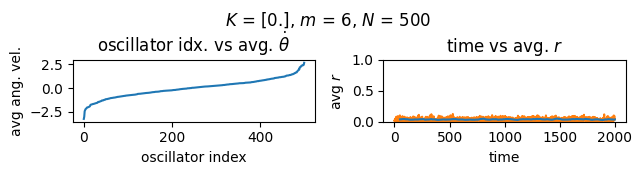

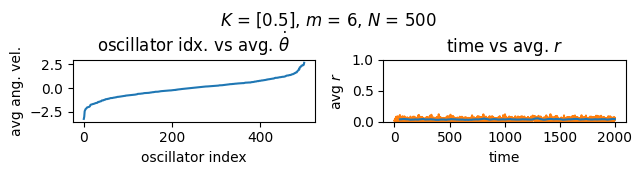

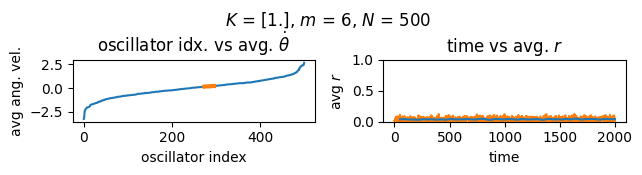

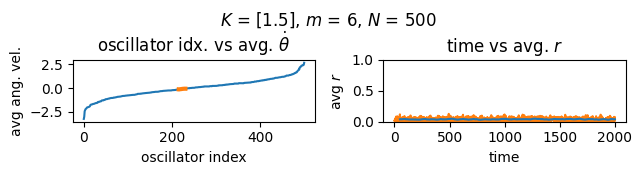

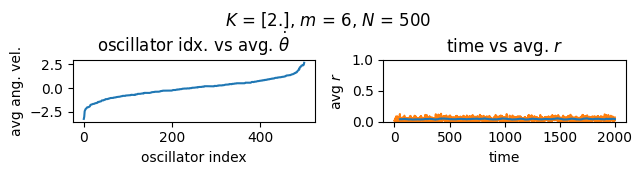

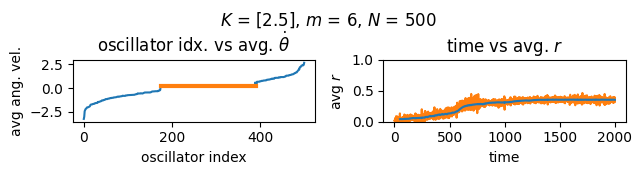

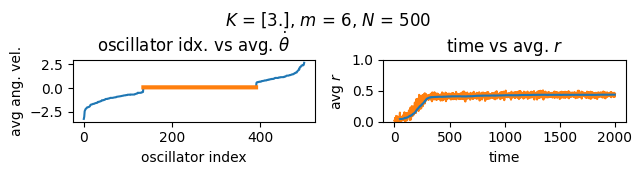

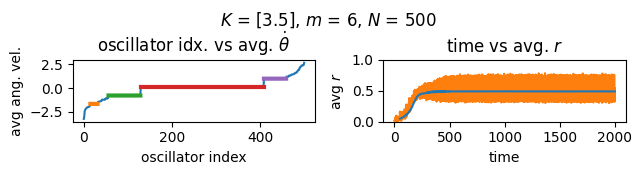

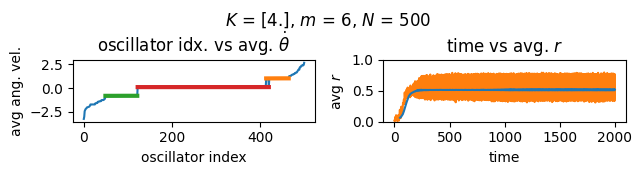

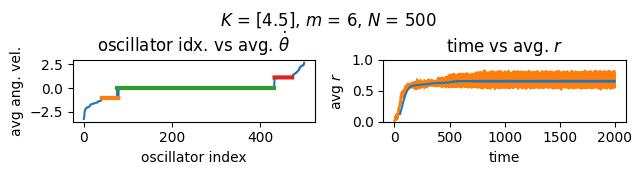

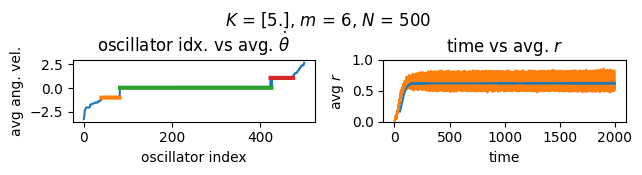

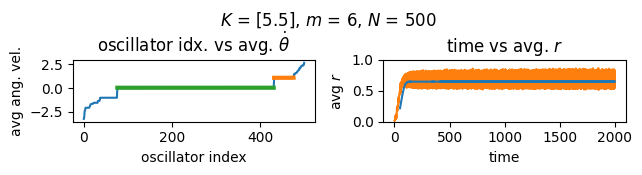

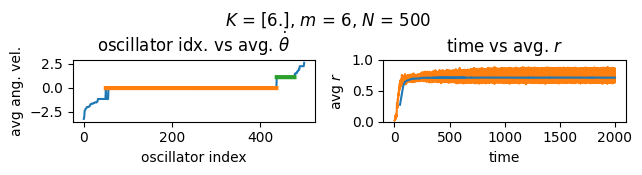

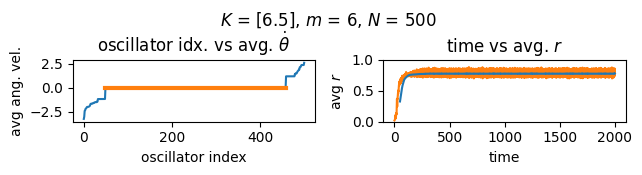

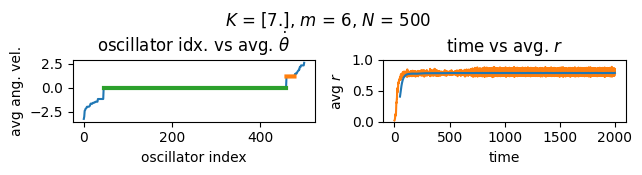

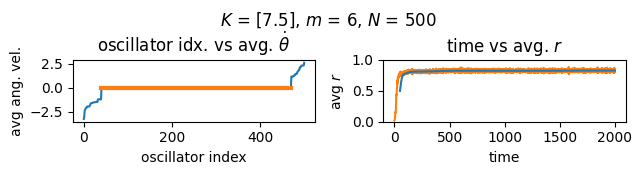

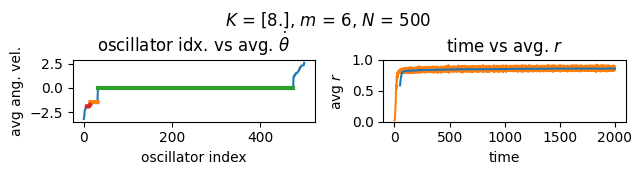

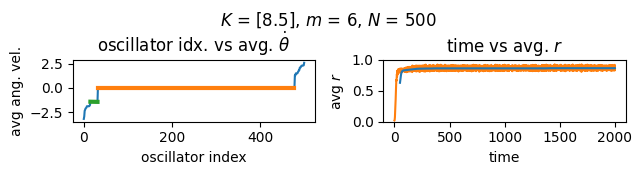

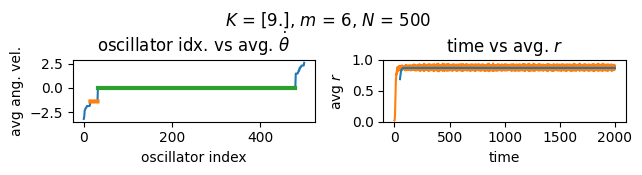

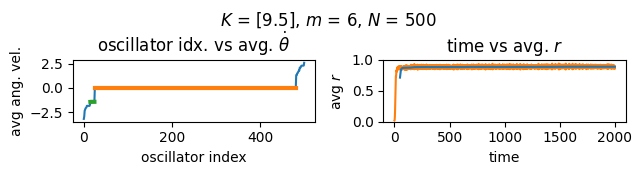

In [452]:
for i in range(N_set):
    avg_dtheta = avg_dtheta_set[:,i]
    CM_S,sCM_O,C_idx,check_ =cluster_os_single(avg_dtheta,N,cidx=True)
    line_ = [np.polyfit(c_idx,avg_dtheta[-1][c_idx],1)[0] for c_idx in C_idx]
    K = K_set[i]
    avg_r = avg_r_set.T[i]
    r = rs.T[0][i]
    print(K,check_,len(line_))
    Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx)
    plt.plot(t,r,zorder=0)

[0.] 1 0
[0.5] 1 0
[1.] 1 0
[1.5] 0 1
[2.] 0 1
[2.5] 0 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[3.] 0 1
[3.5] 0 1
[4.] 0 1
[4.5] 0 1
[5.] 0 1
[5.5] 0 1
[6.] 0 1
[6.5] 0 1
[7.] 0 1
[7.5] 0 1
[8.] 0 1
[8.5] 0 1
[9.] 0 1
[9.5] 0 1


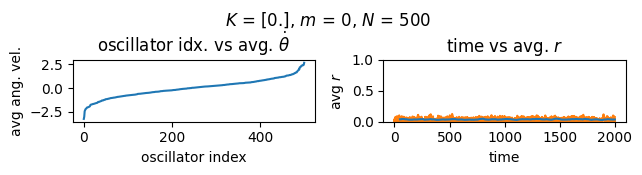

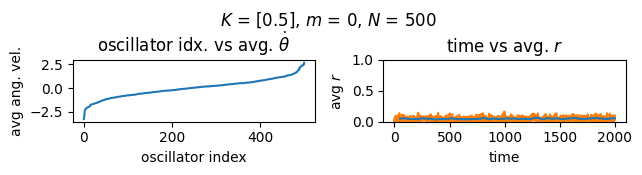

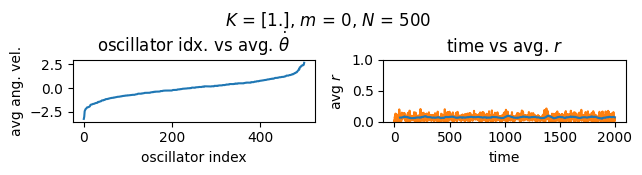

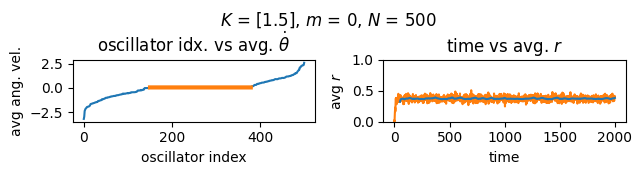

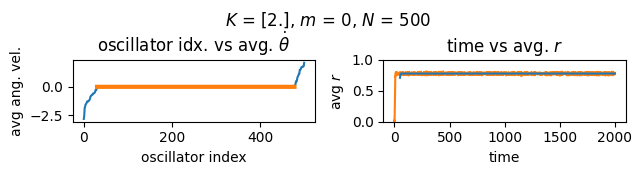

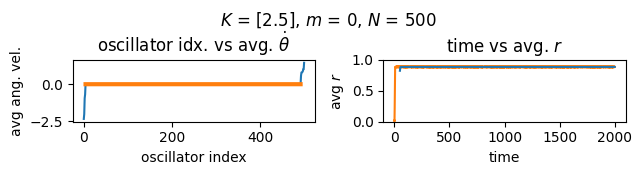

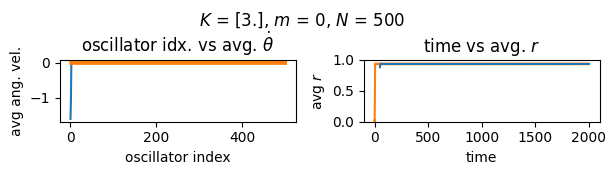

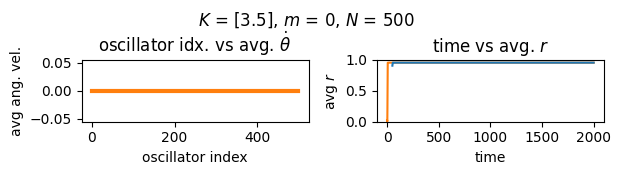

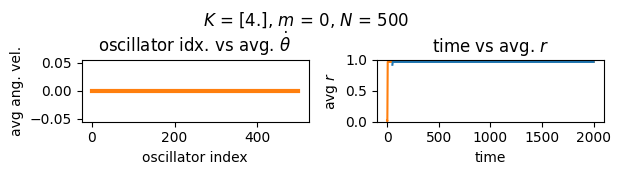

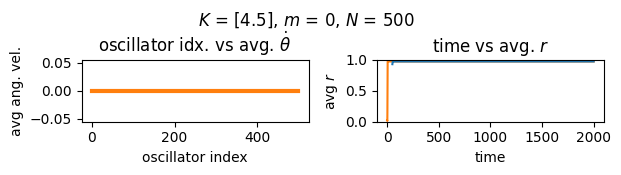

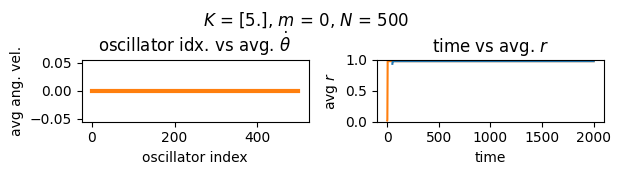

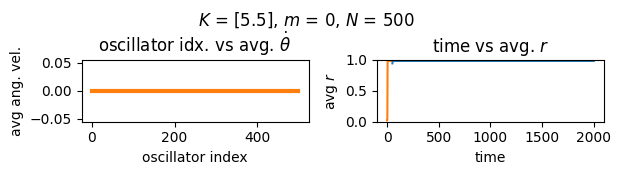

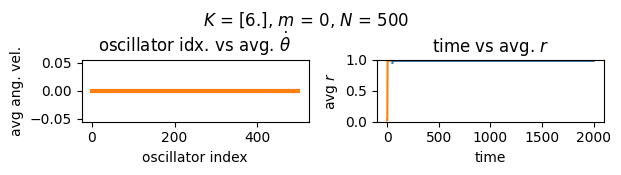

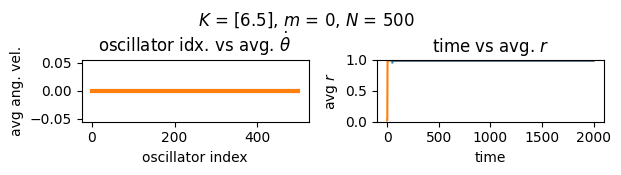

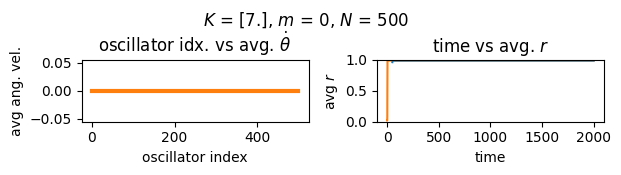

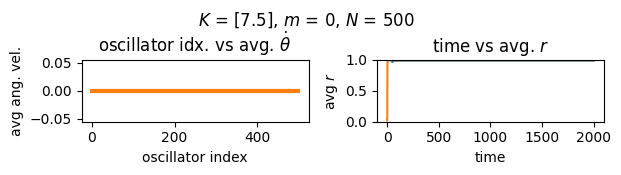

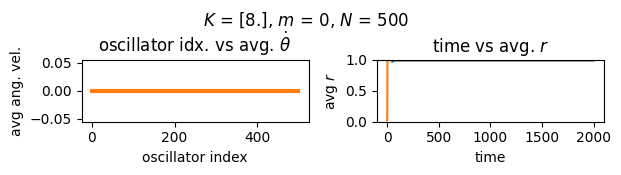

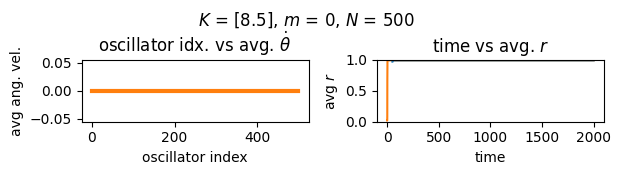

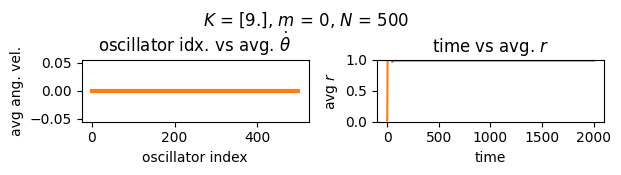

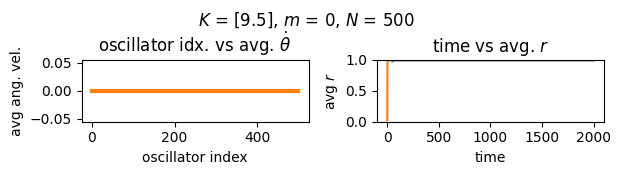

In [26]:
for i in range(N_set):
    avg_dtheta = avg_dtheta_set[:,i]
    CM_S,sCM_O,C_idx,check_,psize_array =cluster_os(avg_dtheta,N,cidx=True,dt=0.01)
    line_ = [np.polyfit(c_idx,avg_dtheta[-1][c_idx],1)[0] for c_idx in C_idx]
    K = K_set[i]
    avg_r = avg_r_set.T[i]
    r = rs.T[0][i]
    print(K,check_,len(line_))
    Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx)
    plt.plot(t,r,zorder=0)

In [40]:
avg_dtheta_set.shape

(1999, 20, 500)

In [38]:
cluster_os(avg_dtheta=avg_dtheta,N=N,dt=dt)

IndexError: index 20 is out of bounds for axis 0 with size 20

In [263]:
K_set.reshape(-1)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

4.0


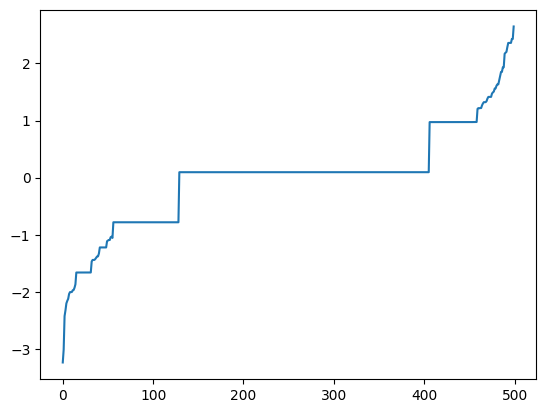

In [267]:
i =8
print(K_set.reshape(-1)[i])
plt.plot(avg_dtheta_set[:,7][-1])

## 새로 만든 알고리즘에서 작은 크기의 클러스터는 확인을 잘 하지 못함.
> 기존의 클러스터를 확인하는 알고리즘이 좀 더 좋은 성능과 일관된 결과를 주는 것 같아  
> 클러스터를 개선만 시켜서 사용함

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2_sets as mf2_sets
from TO_sim.get_cluster import C_rsmso,cluster_os,C_rsmso_set
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap
from scipy.signal import find_peaks
from TO_sim.To_Draw import Draw_avg_vel_r


In [2]:
def cluster_os(avg_dtheta,N,cidx=False,p_array=False,dt=0.1):
    def to_cluster_barg(idx,peaks_new):
        C = idx,idx+1
        arg_C = peaks_new[C[0]],peaks_new[C[1]]
        cluster = np.arange(arg_C[0],arg_C[1])
        return cluster
    def to_cstability(x,diff_dtheta):
        try:
            return np.mean(diff_dtheta[x[1:]])
        except IndexError:
            return np.nan
    def to_mean_avg_d_o(x,avg_dtheta,index):
        try:
            return np.mean(avg_dtheta[index][x])
        except IndexError:
            return np.nan
    iter_time = 1500
    num = 0
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD,SD[-1]])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        
        # peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
            if len(peaks) == 1:
                peaks_new = np.array([peaks[0],N])
        except IndexError:
            peaks_new = np.array([0,N])

        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]
        sort_psize = np.sort(psize)[::-1]
        clusters = np.array([to_cluster_barg(arg,peaks_new) for arg in arg_psize],dtype=object)[:10]
        try:
            if len(clusters) == 1:
                clusters = np.array([np.arange(peaks_new[0],N)])
            c_stability = np.array(list(map(to_cstability,clusters,[diff_dtheta]*len(clusters))))
            mean_omega = np.array(list(map(to_mean_avg_d_o,clusters,[avg_dtheta]*len(clusters),[index]*len(clusters))))
            if num==0:
                psize_array = sort_psize[:10]
                cluster_array = clusters
                c_stability_array = c_stability
                mean_omega_array = mean_omega
                arg_array = arg

                num+=1
            else:
                cluster_array = np.c_[cluster_array,clusters]
                psize_array = np.c_[psize_array,sort_psize[:10]]
                c_stability_array = np.c_[c_stability_array,c_stability]
                mean_omega_array = np.c_[mean_omega_array,mean_omega]
                arg_array = np.c_[arg_array,arg]
        except ValueError:
            pass
            

    Is_group, = np.where((np.std(psize_array,axis=1) == 0)&(psize_array[:,-1]>5))
    check = 0
    mean_group_s = np.mean(c_stability_array,axis=1)
    Is_group2, = np.where((mean_group_s<1e-4)&(psize_array[:,-1]>5))
    Is_group = np.intersect1d(Is_group,Is_group2)
    if len(Is_group)==0:
        check = 1
        mm = np.max(psize_array,axis=1) - np.min(psize_array,axis=1)
        Is_group, = np.where((mean_group_s<7e-4)&(psize_array[:,-1]>5))
        Is_group2, = np.where((mm <= 1)&(psize_array[:,-1]>5))
        Is_group = np.intersect1d(Is_group,Is_group2)

    # if len(Is_group)==0:
    #     check = 2
    #     mean_group_s = np.mean(c_stability_array,axis=1)
    #     Is_group, = np.where((mean_group_s<1e-3)&(psize_array[:,-1]>5))
    CM_O = np.mean(mean_omega_array[Is_group],axis=1)
    sCM_O = np.sort(CM_O)
    sCM_Oidx = np.argsort(CM_O)

    CM_S = np.mean(psize_array[Is_group],axis=1)[sCM_Oidx]
    if cidx == True:
        C_idx = np.array([arg[i] for i in clusters[sCM_Oidx]])
        return CM_S,sCM_O,C_idx,check,psize_array
    if p_array == True:
        return CM_S,sCM_O,C_idx,check,psize_array
    else:
        return CM_S,sCM_O,check

In [ ]:
N_set,len_y = 

In [7]:
1%10

1

In [47]:
def C_rsmso_set(m,K_set,N,theta_init_set,omega_set,pdtheta_set,t_end=5000,dt=0.1):
    t = np.arange(0,t_end,dt)
    _, dtheta_set,rs = mf2_sets(K_set,m=m,N=N,t_array=t,
                                p_theta=theta_init_set,p_dtheta= pdtheta_set,p_omega=omega_set,
                                result_time = int((t_end)-(200))*int(1/dt)-(150)*int(1/dt))
    if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)
    N_set = len(theta_init_set)
    r_duration = rs[-5000:,:]
    r = np.mean(r_duration,axis=0).reshape(-1)
    rstd = np.std(r_duration,axis=0).reshape(-1)
    rMM = (np.max(r_duration,axis=0)-np.min(r_duration,axis=0)).reshape(-1)

    sum_time = 200*int(1/dt)
    if dt == 0.01:
        sum_time = 2000
    dtheta_c = np.cumsum(dtheta_set,axis=0)
    avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
    dtype = [('cluster size', int), ('cluster mean phase velocity', float)]
    CSO_set = []
    check_set = [] 
    for i in range(N_set):
        CM_S,CM_O,check = cluster_os(avg_dtheta=avg_dtheta_set[:,i],N=N,dt=dt)
        CSO = np.array([(S,O) for S,O in zip(CM_S,CM_O)],dtype=dtype)
        CSO_set.append(CSO)
        check_set.append(check)
    return r,rstd,rMM,CSO_set,check_set

In [39]:
K_set = np.arange(0,10,0.5).reshape(-1,1)
seed = 10
m = 0
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_sets = (np.ones((N_set,1))*theta_init)
omega_sets = (np.ones((N_set,1))*omega)


m = 0
t_end = 2000
dt =0.01
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets(K_set,N=N,m=m,t_array=t,p_theta=theta_sets,p_dtheta= 0*omega_sets,p_omega=omega_sets,result_time=int((t_end-300)*(1/dt)))
if m == 0:
        dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)

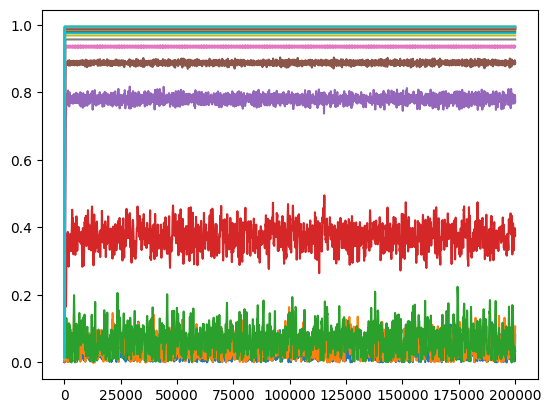

In [40]:
plt.plot(rs.T[0].T)

In [29]:
K_set = np.arange(0,10,0.1).reshape(-1,1)
seed = 10
m = 10
N = 500
dm = 1
ms = np.arange(0,5+dm/2,dm)
# for m in ms:
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
theta_init_set = (np.ones((N_set,1))*theta_init)
pdtheta_set = 0*(np.ones((N_set,1))*omega)
omega_set = (np.ones((N_set,1))*omega)
r,rstd,rMM,CSO_set,check_set = C_rsmso_set(m,K_set,N,theta_init_set,omega_set,pdtheta_set,t_end=300,dt=0.01)

In [30]:
for K,c  in zip(K_set,check_set):
    print(K,c)

[0.] 1
[0.1] 1
[0.2] 1
[0.3] 1
[0.4] 1
[0.5] 1
[0.6] 1
[0.7] 1
[0.8] 1
[0.9] 1
[1.] 1
[1.1] 1
[1.2] 1
[1.3] 1
[1.4] 1
[1.5] 1
[1.6] 1
[1.7] 1
[1.8] 1
[1.9] 1
[2.] 1
[2.1] 1
[2.2] 1
[2.3] 1
[2.4] 1
[2.5] 0
[2.6] 1
[2.7] 1
[2.8] 1
[2.9] 1
[3.] 1
[3.1] 1
[3.2] 1
[3.3] 0
[3.4] 1
[3.5] 1
[3.6] 1
[3.7] 1
[3.8] 1
[3.9] 1
[4.] 1
[4.1] 1
[4.2] 0
[4.3] 1
[4.4] 1
[4.5] 1
[4.6] 1
[4.7] 1
[4.8] 1
[4.9] 0
[5.] 0
[5.1] 1
[5.2] 1
[5.3] 1
[5.4] 0
[5.5] 1
[5.6] 1
[5.7] 1
[5.8] 1
[5.9] 1
[6.] 0
[6.1] 1
[6.2] 1
[6.3] 1
[6.4] 1
[6.5] 0
[6.6] 1
[6.7] 1
[6.8] 0
[6.9] 1
[7.] 1
[7.1] 1
[7.2] 0
[7.3] 1
[7.4] 1
[7.5] 1
[7.6] 1
[7.7] 1
[7.8] 0
[7.9] 1
[8.] 1
[8.1] 1
[8.2] 1
[8.3] 0
[8.4] 1
[8.5] 0
[8.6] 0
[8.7] 1
[8.8] 0
[8.9] 1
[9.] 1
[9.1] 0
[9.2] 0
[9.3] 0
[9.4] 0
[9.5] 0
[9.6] 1
[9.7] 0
[9.8] 0
[9.9] 0


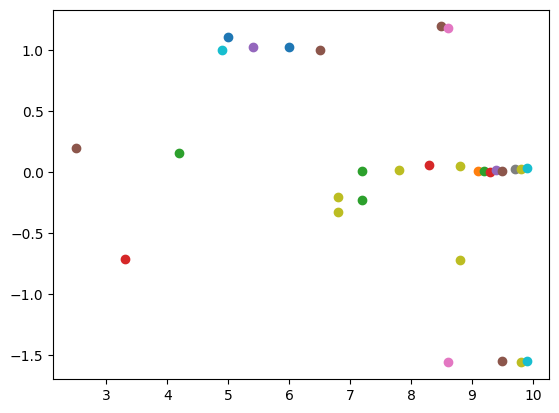

In [31]:
for K,CSO in zip(K_set.reshape(-1),CSO_set):
    x = CSO['cluster mean phase velocity']
    plt.scatter([K]*len(x),x)

In [4]:
dK = 0.1
dm = 0.1
N = 500
seed = 10

theta_init,omega,Kc = Normal(N,0,1,seed=seed)
K_set = np.arange(0,5,dK).reshape(-1,1)

N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
ms = np.arange(0,10+dm/2,dm)
m_set = []
core = 14
index_ = 0
for i in range(len(ms)//core +1):
    m_set.append(ms[index_:index_+core])
    index_ += core
core_set = [len(ms) for ms in m_set]
N_set = len(K_set)
theta_init_set = (np.ones((N_set,1))*theta_init)
pdtheta_set = 0*(np.ones((N_set,1))*omega)
omega_set = (np.ones((N_set,1))*omega)

In [4]:
core_set

[14, 14, 14, 14, 14, 14, 14, 3]

In [5]:
cols ={'r':[0],'rstd':[0],'rMM':[0],'check':[0]}
for i in range(10):
    cols[f'c{i}'] = np.nan
for i in range(10):
    cols[f'c{i} omega'] = np.nan

cols['K'] = K_set.reshape(-1)[0]
cols['m'] = ms[0]
df = pd.DataFrame(cols)
df_Km = df.set_index(['K','m'])

In [6]:
for core,ms in zip(core_set,m_set):
    for m,(r,rstd,rMM,CSO_set,check_set) in zip(ms,parmap.map(C_rsmso_set,ms,K_set=K_set,N=N,theta_init_set=theta_init_set,
                                                        omega_set=omega_set,pdtheta_set = pdtheta_set,t_end=2000,dt=0.01,
                                                        pm_pbar=True, pm_processes=core)):
        for i,K in enumerate(K_set.reshape(-1)):
            df_Km.loc[(K,m),"r"] = r[i]
            df_Km.loc[(K,m),"rstd"] = rstd[i]
            df_Km.loc[(K,m),"rMM"] = rMM[i]
            df_Km.loc[(K,m),'check'] = check_set[i]
            CSO = CSO_set[i]
            for i in range(len(CSO_set[i])):
                    df_Km.loc[(K,m),f'c{i}'] = CSO['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSO['cluster mean phase velocity'][i]

  0%|          | 0/14 [00:00<?, ?it/s]

MemoryError: Unable to allocate 13.0 GiB for an array with shape (35000, 50, 1000) and data type float64

In [ ]:
K_set = np.arange(5,10+dK/2,dK).reshape(-1,1)
N_set = len(K_set)
omega = np.sort(omega) - np.mean(omega)
ms = np.arange(0,10+dm/2,dm)
m_set = []
core = 8
index_ = 0
for i in range(len(ms)//core +1):
    m_set.append(ms[index_:index_+core])
    index_ += core
core_set = [len(ms) for ms in m_set]
N_set = len(K_set)
theta_init_set = (np.ones((N_set,1))*theta_init)
pdtheta_set = 0*(np.ones((N_set,1))*omega)
omega_set = (np.ones((N_set,1))*omega)
for core,ms in zip(core_set,m_set):
    for m,(r,rstd,rMM,CSO_set,check_set) in zip(ms,parmap.map(C_rsmso_set,ms,K_set=K_set,N=N,theta_init_set=theta_init_set,
                                                        omega_set=omega_set,pdtheta_set = pdtheta_set,t_end=2000,dt=0.01,
                                                        pm_pbar=True, pm_processes=core)):
        for i,K in enumerate(K_set.reshape(-1)):
            df_Km.loc[(K,m),"r"] = r[i]
            df_Km.loc[(K,m),"rstd"] = rstd[i]
            df_Km.loc[(K,m),"rMM"] = rMM[i]
            df_Km.loc[(K,m),'check'] = check_set[i]
            CSO = CSO_set[i]
            for i in range(len(CSO_set[i])):
                    df_Km.loc[(K,m),f'c{i}'] = CSO['cluster size'][i]
                    df_Km.loc[(K,m),f'c{i} omega'] = CSO['cluster mean phase velocity'][i]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dty

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
df_Km

,,r,rstd,rMM,check,c0,c1,c2,c3,c4,c5,...,c0 omega,c1 omega,c2 omega,c3 omega,c4 omega,c5 omega,c6 omega,c7 omega,c8 omega,c9 omega
K,m,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.037467,0.020066,0.118610,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,0.0,0.039385,0.021303,0.121755,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,0.0,0.041601,0.022916,0.121747,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,0.0,0.044947,0.024328,0.142298,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,0.0,0.048034,0.023979,0.149513,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.6,10.0,0.806045,0.039134,0.199104,0.0,18.0,417.0,19.0,NaN,NaN,NaN,...,-1.545675,0.024133,1.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.7,10.0,0.817761,0.044441,0.208281,0.0,26.0,422.0,NaN,NaN,NaN,NaN,...,-1.476867,0.022690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.8,10.0,0.822440,0.043049,0.183922,0.0,25.0,424.0,NaN,NaN,NaN,NaN,...,-1.409773,0.019284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


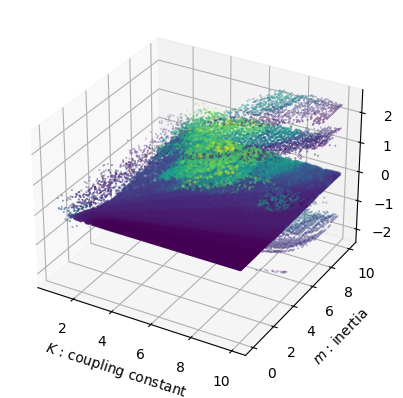

In [21]:
df = df_Km
KK = df.index.to_frame().K.unstack().to_numpy().T
MM = df.index.to_frame().m.unstack().to_numpy().T

Ks = df.reset_index().K
ms = df.reset_index().m
Ss_c0 = df.reset_index()['c0'].to_numpy()
Ss_c1 = df.reset_index()['c1'].to_numpy()
Ss_c2 = df.reset_index()['c2'].to_numpy()
Ss_c3 = df.reset_index()['c3'].to_numpy()
Ss_c4 = df.reset_index()['c4'].to_numpy()
Ss_c5 = df.reset_index()['c5'].to_numpy()
So_c0 = df.reset_index()['c0 omega'].to_numpy()
So_c1 = df.reset_index()['c1 omega'].to_numpy()
So_c2 = df.reset_index()['c2 omega'].to_numpy()
So_c3 = df.reset_index()['c3 omega'].to_numpy()
So_c4 = df.reset_index()['c4 omega'].to_numpy()
So_c5 = df.reset_index()['c5 omega'].to_numpy()

rMM = df.reset_index()['rMM']


# plt.subplot(projection='3d')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Ks,ms,So_c0,c=rMM,s=Ss_c0*0.01)
ax.scatter(Ks,ms,So_c1,c=rMM,s=Ss_c1*0.01)
ax.scatter(Ks,ms,So_c2,c=rMM,s=Ss_c2*0.01)
ax.scatter(Ks,ms,So_c3,c=rMM,s=Ss_c3*0.01)
ax.scatter(Ks,ms,So_c4,c=rMM,s=Ss_c4*0.01)
ax.scatter(Ks,ms,So_c5,c=rMM,s=Ss_c5*0.01)

ax.set_xlabel('$K$ : coupling constant')
ax.set_ylabel('$m$ : inertia')
ax.set_zlabel('cluster phase velocity')
# plt.zlim(-0.)
# plt.scatter(Ks,ms,Ss,Ss)
plt.show()


In [14]:
df

,,r,rstd,rMM,check,c0,c1,c2,c3,c4,c5,...,c0 omega,c1 omega,c2 omega,c3 omega,c4 omega,c5 omega,c6 omega,c7 omega,c8 omega,c9 omega
K,m,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.037467,0.020066,0.118610,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1,0.0,0.039385,0.021303,0.121755,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2,0.0,0.041601,0.022916,0.121747,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3,0.0,0.044947,0.024328,0.142298,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.4,0.0,0.048034,0.023979,0.149513,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.6,10.0,0.806045,0.039134,0.199104,0.0,18.0,417.0,19.0,NaN,NaN,NaN,...,-1.545675,0.024133,1.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.7,10.0,0.817761,0.044441,0.208281,0.0,26.0,422.0,NaN,NaN,NaN,NaN,...,-1.476867,0.022690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.8,10.0,0.822440,0.043049,0.183922,0.0,25.0,424.0,NaN,NaN,NaN,NaN,...,-1.409773,0.019284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ms

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

array([0.1738235 , 0.16982386, 0.08754815, 0.17340487, 0.17861553,
       0.16532183, 0.16697293, 0.19482136, 0.15884662, 0.17410226,
       0.16709784, 0.13008259, 0.17171265, 0.17045531, 0.16110742,
       0.13786574, 0.16760652, 0.16574219, 0.12145744, 0.12108693,
       0.1254246 , 0.10595156, 0.10875747, 0.12614009, 0.12836547,
       0.11111106, 0.11880116, 0.12997421, 0.11436856, 0.10623526,
       0.11072306, 0.09539174, 0.10041654, 0.06889318, 0.06288578,
       0.06965988, 0.07488646, 0.06749376, 0.0765917 , 0.04924743,
       0.05318734, 0.04825818, 0.04573567, 0.05143502, 0.04536727,
       0.04566254, 0.03913443, 0.0444412 , 0.04304884, 0.04222076,
       0.02977731])

In [29]:
print(df_m.check.to_numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


80
76
76
77
80
79
82
79
78
78


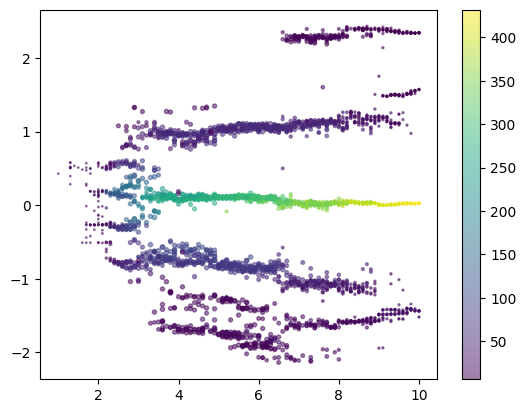

In [23]:
for i in range(91,101):
    m_idx = i
    ms = df.reset_index().m.unique()
    re_df = df.reset_index()

    df_m = re_df[re_df.m == ms[m_idx]]
    Ks = df_m.K.to_numpy()
    rs = df_m.r.to_numpy()
    rstd = df_m.rstd.to_numpy()
    rMM= df_m.rMM.to_numpy()
    cluster_s = df_m.iloc[:,5:15]
    cluster_o = df_m.iloc[:,15:25]
    print(len(cluster_s['c1'].dropna()))
    plt.scatter(np.ones((10,101))*Ks,(cluster_o.to_numpy().T),c=cluster_s.to_numpy().T,alpha=0.5,
                s=50*np.ones((10,101))*rstd)
plt.colorbar()

In [24]:
# df_Km.sort_index().to_excel(f'N = {N} seed = {seed} test 230627.xlsm')
df_Km.sort_index().to_excel(f'N = {N} seed = {seed} test 230627 with initial phase vel.xlsm')

In [12]:
CSO_set

[array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity', '<f8')]),
 array([],
       dtype=[('cluster size', '<i8'), ('cluster mean phase velocity'

In [7]:
for CSO  in CSO_set:
    print(len(CSO['cluster size']),end = ' ')
for CSO  in CSO_set:
    print(CSO['cluster size'])


0 0 0 0 0 1 1 4 3 3 3 2 3 3 2 1 2 2 2 1 []
[]
[]
[]
[]
[217]
[255]
[ 17  73 279  51]
[ 73 292  51]
[ 36 355  39]
[ 42 342  48]
[ 39 355]
[ 23 382  41]
[ 17 409  20]
[414  19]
[430]
[ 17 443]
[ 17 446]
[ 17 448]
[456]


In [23]:
t_end=2000
dt=0.01
t = np.arange(0,t_end,dt)
theta_set, dtheta_set,rs = mf2_sets(K_set,m=m,N=N,t_array=t,
                                p_theta=theta_init_set,p_dtheta= pdtheta_set,p_omega=omega_set,
                                result_time = int((t_end)-(500))*int(1/dt)-1000)
if m == 0:
    dtheta_set = np.concatenate((dtheta_set[0].reshape(1,-1,N),dtheta_set),0)
N_set = len(theta_init_set)
r_duration = rs[-5000:,:]
r = np.mean(r_duration,axis=0).reshape(-1)
rstd = np.std(r_duration,axis=0).reshape(-1)
rMM = np.max(r_duration)-np.min(r_duration)
sum_time = 500*int(1/dt)
dtheta_c = np.cumsum(dtheta_set,axis=0)
avg_dtheta_set = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

[0.] 1 0
[0.5] 1 0
[1.] 1 0
[1.5] 1 0
[2.] 1 0
[2.5] 0 1
[3.] 0 1
[3.5] 0 3
[4.] 0 3
[4.5] 0 2
[5.] 0 3
[5.5] 0 3
[6.] 0 2
[6.5] 0 3
[7.] 0 2
[7.5] 0 1
[8.] 0 1
[8.5] 0 2
[9.] 0 2
[9.5] 0 1


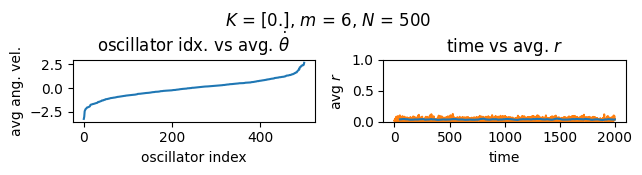

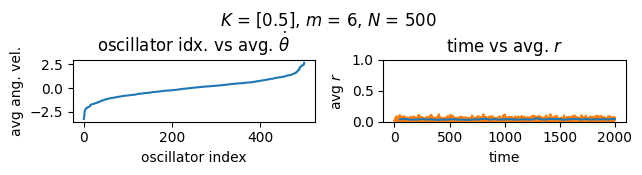

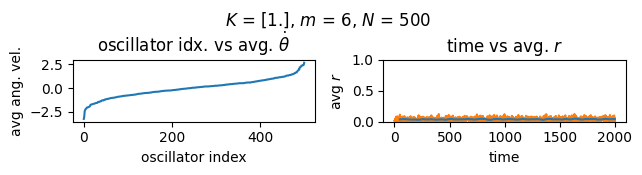

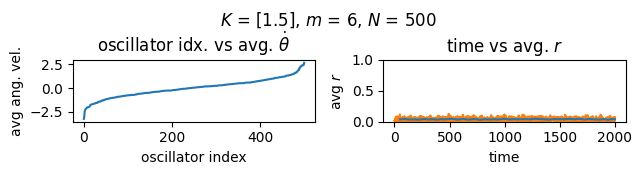

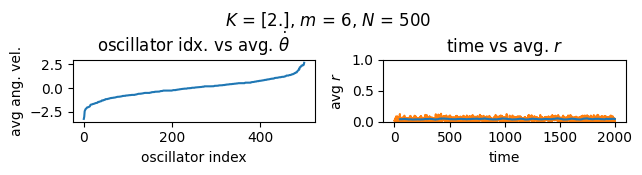

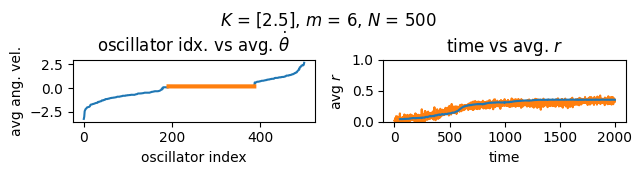

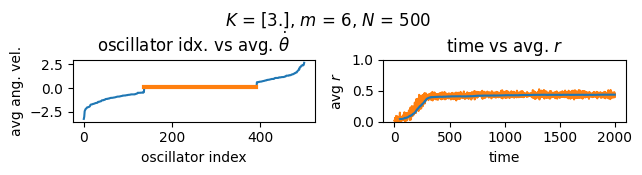

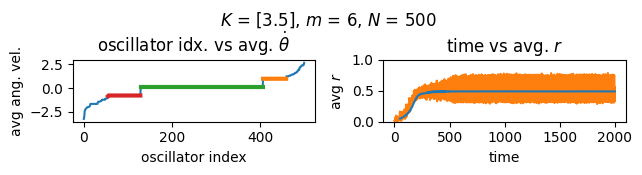

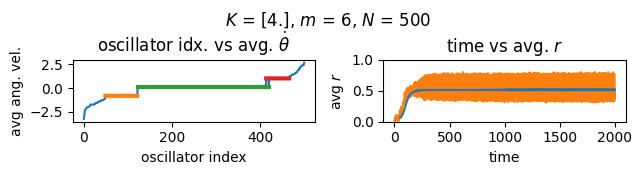

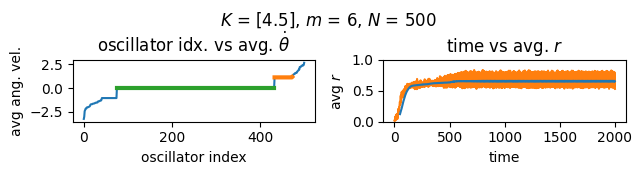

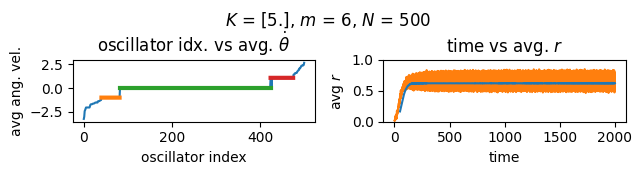

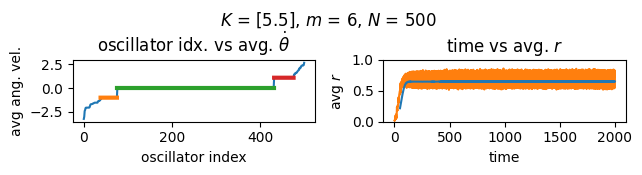

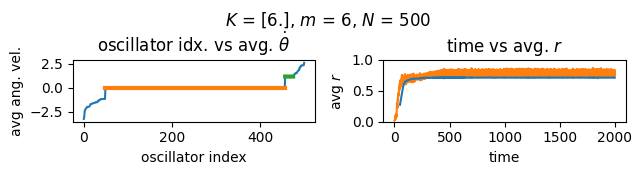

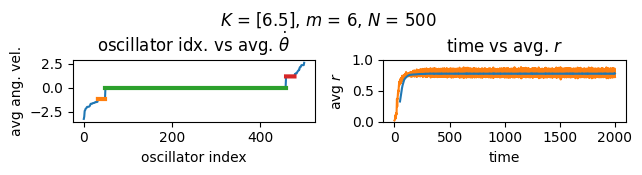

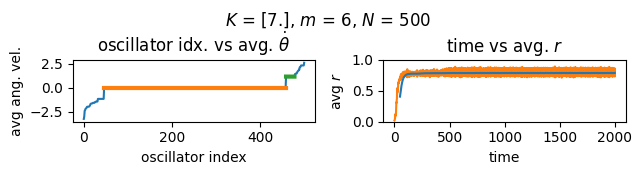

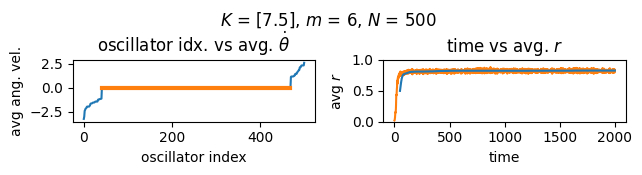

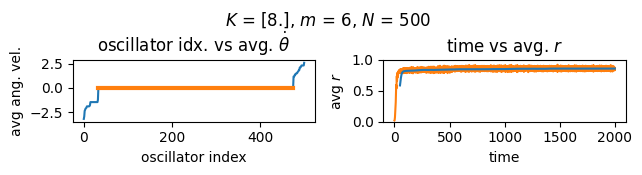

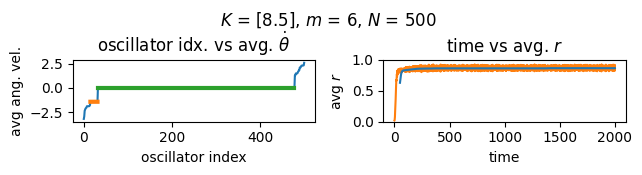

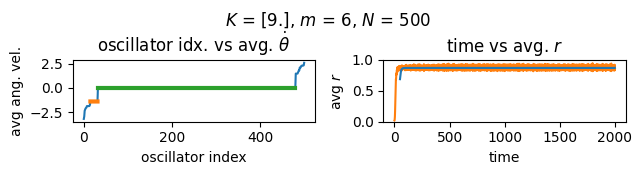

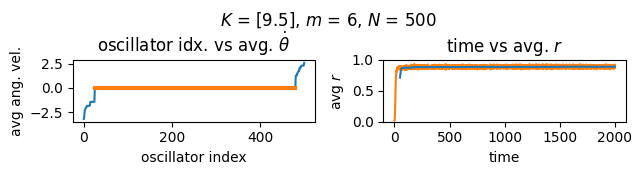

In [24]:
for i in range(N_set):
    avg_dtheta = avg_dtheta_set[:,i]
    CM_S,sCM_O,C_idx,check_,psize_array =cluster_os(avg_dtheta,N,cidx=True,dt=0.01)
    line_ = [np.polyfit(c_idx,avg_dtheta[-1][c_idx],1)[0] for c_idx in C_idx]
    K = K_set[i]
    avg_r = avg_r_set.T[i]
    r_ = rs.T[0][i]
    print(K,check_,len(line_))
    Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta,Cidx=C_idx)
    plt.plot(t,r_,zorder=0)

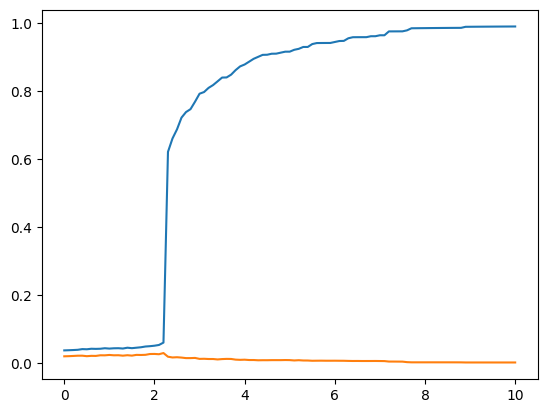

In [13]:
plt.plot(K_set.reshape(-1),r)
plt.plot(K_set.reshape(-1),rstd)